# КЕЙС ЧЕМПИОНАТ ПЕТРА ВЕЛИКОГО

ЗАДАЧА КЕЙСА -
прогнозирование поломок
оборудования и расчет остаточного
ресурса оборудования на примере блока розлива баночного пива KHS Innofill DMD 108 (2002 года выпуска). Это карусельный аппарат с множеством механических деталей, который проходит через стадии вакуумизации, заполнения газом, розлива, успокоения жидкости и передачи банки на закатку.

Нужно спрогнозировать время до следующей поломки на основе данных о простоях, а также рассчитать остаточный ресурс, анализируя такие параметры, как MTBF, MTTR, MTBS, моточасы, частоту поломок и техническое состояние узлов.

## Установка и импорт библиотек

In [ ]:
!pip install -q phik

In [ ]:
!pip install catboost

In [ ]:
!pip install tensorflow

In [ ]:
# Импорт библиотек

import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.stem.snowball import SnowballStemmer
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.cluster import KMeans
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVR

import lightgbm as lgb
from catboost import CatBoostRegressor
import phik

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Открытие файла

In [ ]:
# Открытие файла
file_path = 'Поломки_Блок Розлива_2020-2024v2.xlsx'
data = pd.read_excel(file_path)

data.head()

,Начало простоя,Конец простоя,Reason 3 (ID),Reason 3 (ENG),Описание,Длительность
0,08-янв-20 02:04:44,08-янв-20 02:08:29,2010004.0,Breakdowns,Замена двух дросселей на наполнителе №17,3.750000
1,28-янв-20 09:11:45,28-янв-20 09:20:46,2010004.0,Breakdowns,Замена первого ролика на столике №1,9.016667
2,05-фев-20 10:40:01,05-фев-20 10:42:23,2010004.0,Breakdowns,Замена нагнетательного дросселя №89,2.366667
3,06-фев-20 10:59:58,06-фев-20 11:04:09,2010004.0,Breakdowns,Замена нагнетательного дросселя №105,4.183333
4,06-фев-20 19:02:48,06-фев-20 19:05:07,2010004.0,Breakdowns,Замена тормозной пластины №76,2.316667


In [ ]:
# Информация
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Начало простоя  532 non-null    object 
 1   Конец простоя   531 non-null    object 
 2   Reason 3 (ID)   531 non-null    float64
 3   Reason 3 (ENG)  531 non-null    object 
 4   Описание        531 non-null    object 
 5   Длительность    532 non-null    float64
dtypes: float64(2), object(4)
memory usage: 25.1+ KB


## Предобработка данных

В таблице видны пропуски и неверный формат данных в некоторых столбцах. Начинаем с пропусков, так как их мало. Выводим пропуск для ознакомления.

In [ ]:
# Пропуск
data[data.isna().any(axis=1)]

,Начало простоя,Конец простоя,Reason 3 (ID),Reason 3 (ENG),Описание,Длительность
531,Общий итог,NaN,NaN,NaN,NaN,3253.0


Для таблицы с данными эта строка не имеет никакой полезной информации, удаляем ее.

In [ ]:
# Удаление пропуска
data = data.iloc[:-1]
print(data.tail())

         Начало простоя       Конец простоя  Reason 3 (ID) Reason 3 (ENG)  \
526  04-ноя-24 16:04:20  04-ноя-24 16:07:21      2010004.0     Breakdowns   
527  04-ноя-24 19:15:34  04-ноя-24 19:17:41      2010004.0     Breakdowns   
528  05-ноя-24 09:48:48  05-ноя-24 09:51:31      2010004.0     Breakdowns   
529  21-ноя-24 03:12:49  21-ноя-24 03:16:28      2010004.0     Breakdowns   
530  21-ноя-24 03:24:45  21-ноя-24 03:28:36      2010004.0     Breakdowns   

                                         Описание  Длительность  
526  Замена тормозной пластины на 10 наполнителе.      3.016667  
527   Замена тормозной пластины на 66 наполнителе      2.100000  
528                     замена тормозной пластины      2.716667  
529       МЕХ. Недолив. Пустые банки. 20/32/33/39      3.650000  
530       МЕХ. Недолив. Пустые банки. 20/32/33/39      3.833333  


Разбираемся с форматом данных. В столбцах "Начало простоя" и "Конец простоя" месяц указан сокращенными русскими буквами, поэтому не получилось сразу заменить формат. Для начала надо русские буквы заменить английскими.

In [ ]:
# Замена русских месяцев на английские
months_translation = {
    "янв": "Jan", "фев": "Feb", "мар": "Mar", "апр": "Apr",
    "май": "May", "июн": "Jun", "июл": "Jul", "авг": "Aug",
    "сен": "Sep", "окт": "Oct", "ноя": "Nov", "дек": "Dec"
}

def translate_months(date_str):
    if isinstance(date_str, str):
        for ru_month, en_month in months_translation.items():
            date_str = date_str.replace(ru_month, en_month)
    return date_str

data['Начало простоя'] = data['Начало простоя'].apply(translate_months)
data['Конец простоя'] = data['Конец простоя'].apply(translate_months)

data['Начало простоя'] = pd.to_datetime(data['Начало простоя'], format='%d-%b-%y %H:%M:%S', errors='coerce')
data['Конец простоя'] = pd.to_datetime(data['Конец простоя'], format='%d-%b-%y %H:%M:%S', errors='coerce')

print(data.dtypes)
print(data.head())

Начало простоя    datetime64[ns]
Конец простоя     datetime64[ns]
Reason 3 (ID)            float64
Reason 3 (ENG)            object
Описание                  object
Длительность             float64
dtype: object
       Начало простоя       Конец простоя  Reason 3 (ID) Reason 3 (ENG)  \
0 2020-01-08 02:04:44 2020-01-08 02:08:29      2010004.0     Breakdowns   
1 2020-01-28 09:11:45 2020-01-28 09:20:46      2010004.0     Breakdowns   
2 2020-02-05 10:40:01 2020-02-05 10:42:23      2010004.0     Breakdowns   
3 2020-02-06 10:59:58 2020-02-06 11:04:09      2010004.0     Breakdowns   
4 2020-02-06 19:02:48 2020-02-06 19:05:07      2010004.0     Breakdowns   

                                   Описание  Длительность  
0  Замена двух дросселей на наполнителе №17      3.750000  
1       Замена первого ролика на столике №1      9.016667  
2       Замена нагнетательного дросселя №89      2.366667  
3      Замена нагнетательного дросселя №105      4.183333  
4             Замена тормозной пласти

В столбце с идентификатором поломок тоже меняем тип данных.

In [ ]:
# Преобразуем столбец в целое число
data['Reason 3 (ID)'] = data['Reason 3 (ID)'].astype(int)

data['Reason 3 (ID)'].dtype

dtype('int64')

In [ ]:
# Статистический обзор
data.describe()

,Начало простоя,Конец простоя,Reason 3 (ID),Длительность
count,531,531,5.310000e+02,531.000000
mean,2022-01-26 17:41:28.732579840,2022-01-26 17:47:36.073446400,2.010004e+06,6.117389
min,2020-01-08 02:04:44,2020-01-08 02:08:29,2.010003e+06,2.033333
25%,2021-03-30 09:55:06.500000,2021-03-30 09:58:36.500000,2.010004e+06,3.125000
50%,2022-02-03 14:04:06,2022-02-03 14:07:36,2.010004e+06,4.266667
75%,2022-11-15 18:41:40.500000,2022-11-15 18:47:59,2.010004e+06,5.916667
max,2024-11-21 03:24:45,2024-11-21 03:28:36,2.010004e+06,110.266667
std,NaN,NaN,7.502265e-02,9.160828


In [ ]:
# Уникальные значения в Reason 3 (ENG) и Reason 3 (ID)
print(data['Reason 3 (ENG)'].unique())
print(data['Reason 3 (ID)'].unique())


['Breakdowns' 'Поломки/КИП']
[2010004 2010003]


Так же важно посмотреть пропуски, дубликаты, максимальные и минимальные даты в таблице.

In [ ]:
# Важная информация
print(data[['Начало простоя', 'Конец простоя']].isna().sum())
print(data[['Начало простоя', 'Конец простоя']].duplicated().sum())
print(data.sort_values('Начало простоя').head(10))
print(data.sort_values('Конец простоя', ascending=False).head(10))

Начало простоя    0
Конец простоя     0
dtype: int64
0
       Начало простоя       Конец простоя  Reason 3 (ID) Reason 3 (ENG)  \
0 2020-01-08 02:04:44 2020-01-08 02:08:29        2010004     Breakdowns   
1 2020-01-28 09:11:45 2020-01-28 09:20:46        2010004     Breakdowns   
2 2020-02-05 10:40:01 2020-02-05 10:42:23        2010004     Breakdowns   
3 2020-02-06 10:59:58 2020-02-06 11:04:09        2010004     Breakdowns   
4 2020-02-06 19:02:48 2020-02-06 19:05:07        2010004     Breakdowns   
5 2020-02-08 04:00:32 2020-02-08 04:07:14        2010004     Breakdowns   
6 2020-02-27 04:35:28 2020-02-27 04:37:37        2010004     Breakdowns   
7 2020-02-28 20:47:37 2020-02-28 20:51:43        2010004     Breakdowns   
8 2020-02-28 21:27:07 2020-02-28 21:31:19        2010004     Breakdowns   
9 2020-03-04 03:57:44 2020-03-04 04:01:11        2010004     Breakdowns   

                                            Описание  Длительность  
0           Замена двух дросселей на наполнителе №

В столбце "Описание" замечено написание текста разным регистром, и при беглом осмотре таблицы были замечены странные записи, предположительно неправильная раскладка использовалась. Надо найти эти строки и исправить текст.

In [ ]:
# Поиск строк с неправильной раскладкой
def find_incorrect_layout(text):
    if re.search(r'[a-zA-Z]', text):
        return True
    return False

incorrect_rows = data[data['Описание'].apply(find_incorrect_layout)]

print(incorrect_rows[['Описание']])


                  Описание
422  pfvtyf yfgjkybntkz 96


In [ ]:
# Исправление раскладки
def fix_layout(text):
    correct = "фисвуапршолдьтщзйкыегмцчня"
    incorrect = "abcdefghijklmnopqrstuvwxyz"

    trans_table = str.maketrans(incorrect + incorrect.upper(), correct + correct.upper())
    return text.translate(trans_table)

data.loc[422, "Описание"] = fix_layout(data.loc[422, "Описание"])

data.iloc[422]


,422
Начало простоя,2023-02-01 20:03:22
Конец простоя,2023-02-01 20:12:28
Reason 3 (ID),2010004
Reason 3 (ENG),Breakdowns
Описание,замена наполнителя 96
Длительность,9.1


In [ ]:
# Регистр
data['Описание'] = data['Описание'].str.lower().str.strip()
data['Описание']

,Описание
0,замена двух дросселей на наполнителе №17
1,замена первого ролика на столике №1
2,замена нагнетательного дросселя №89
3,замена нагнетательного дросселя №105
4,замена тормозной пластины №76
...,...
526,замена тормозной пластины на 10 наполнителе.
527,замена тормозной пластины на 66 наполнителе
528,замена тормозной пластины
529,мех. недолив. пустые банки. 20/32/33/39


В столбце "Reason 3 (ENG)" указаны причины поломки, их всего две, но если не рассматривать пристально всю таблицу, то видна всегда одна и таже поломка. При более подробном изучении столбца было замечено, что если смотреть на описание, то столбец с поломкой размечен неверно. Встречается в описание проблема или устранение неполадок связанных с КИП, а в столбце с причиной это не отражено. Поэтому будем находить строчки с неправильной разметкой и преобразовывать их.

In [ ]:
# Фильтруем строки - "Поломки/КИП"
kip_breakdowns = data[data["Reason 3 (ENG)"] == "Поломки/КИП"]

print(kip_breakdowns)

        Начало простоя       Конец простоя  Reason 3 (ID) Reason 3 (ENG)  \
18 2020-04-08 21:31:21 2020-04-08 21:37:13        2010003    Поломки/КИП   
32 2020-05-14 23:06:22 2020-05-14 23:11:47        2010003    Поломки/КИП   
55 2020-07-14 04:58:52 2020-07-14 05:10:04        2010003    Поломки/КИП   

                                             Описание  Длительность  
18                                      замена домино      5.866667  
32              не отрабатывает датчик на мятую банку      5.416667  
55  произошло опорожнение котла блока розлива. уро...     11.200000  


In [ ]:
# Преобразование
def correct_reason(description, reason, reason_id):
    kip_keywords = ["датчик", "кип"]

    if any(re.search(keyword, description, re.IGNORECASE) for keyword in kip_keywords):
        return "Поломки/КИП", 2010003
    return reason, reason_id

data[["Reason 3 (ENG)", "Reason 3 (ID)"]] = data.apply(
    lambda row: pd.Series(correct_reason(row["Описание"], row["Reason 3 (ENG)"], row["Reason 3 (ID)"])), axis=1
)

kip_breakdowns = data[data["Reason 3 (ENG)"] == "Поломки/КИП"]
kip_breakdowns

,Начало простоя,Конец простоя,Reason 3 (ID),Reason 3 (ENG),Описание,Длительность
18,2020-04-08 21:31:21,2020-04-08 21:37:13,2010003,Поломки/КИП,замена домино,5.866667
32,2020-05-14 23:06:22,2020-05-14 23:11:47,2010003,Поломки/КИП,не отрабатывает датчик на мятую банку,5.416667
55,2020-07-14 04:58:52,2020-07-14 05:10:04,2010003,Поломки/КИП,произошло опорожнение котла блока розлива. уро...,11.200000
93,2020-09-24 11:19:55,2020-09-24 11:27:10,2010003,Поломки/КИП,"не всегда отрабатывает датчик на мятую банку, ...",7.250000
94,2020-09-24 12:46:26,2020-09-24 13:24:54,2010003,Поломки/КИП,"не всегда отрабатывает датчик на мятую банку, ...",38.466667
96,2020-09-25 02:27:41,2020-09-25 02:30:24,2010003,Поломки/КИП,"кип, не работает датчик на мятую банку в укупоре.",2.716667
131,2021-03-23 08:17:47,2021-03-23 08:26:22,2010003,Поломки/КИП,кип. не закрыта передняя облицовачная дверь бл...,8.583333
142,2021-05-14 09:45:17,2021-05-14 09:49:26,2010003,Поломки/КИП,замена датчика закатки,4.150000
162,2021-06-23 07:27:37,2021-06-23 07:34:33,2010003,Поломки/КИП,"мех, кип. сбой пластичной смазки.",6.933333
165,2021-06-24 05:50:41,2021-06-24 05:53:55,2010003,Поломки/КИП,мех. кип. сбой толкателя пластичной смазки.,3.233333


## Исследование данных

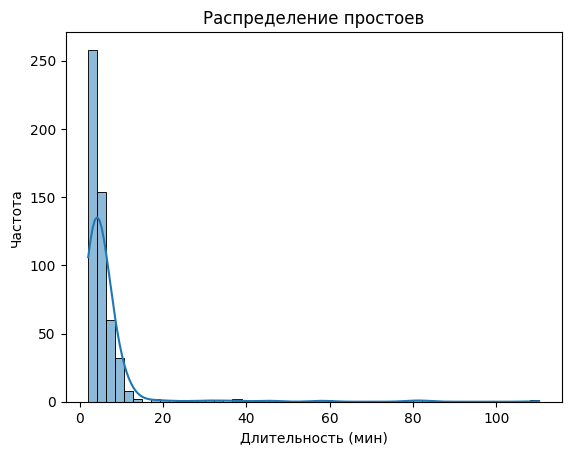

In [ ]:
# Распределение простоев
sns.histplot(data['Длительность'], bins=50, kde=True)
plt.xlabel('Длительность (мин)')
plt.ylabel('Частота')
plt.title('Распределение простоев')
plt.show()

Наибольшее количество простоев - около 250 имеет очень короткую длительность, близкую к нулю. Это указывает на то, что большинство простоев являются кратковременными.

По мере увеличения длительности простоев, частота их возникновения резко снижается. Простои с длительностью более 20 минут встречаются значительно реже.

Кривая плотности вероятности подтверждает тенденцию - большинство простоев сосредоточено в коротком временном интервале, а затем частота быстро уменьшается. Распределение можно описать как сильно смещённое влево (правосторонне смещённое).

Есть несколько выбросов для простоев с длительностью более 60 минут, но их частота крайне мала.

Это распределение говорит о том, что большинство простоев имеют кратковременный характер, и лишь небольшая часть из них затягивается на значительное время. Для оптимизации процессов важно обратить внимание на причины этих долгих простоев, так как они могут иметь наибольший негативный эффект на производстве.


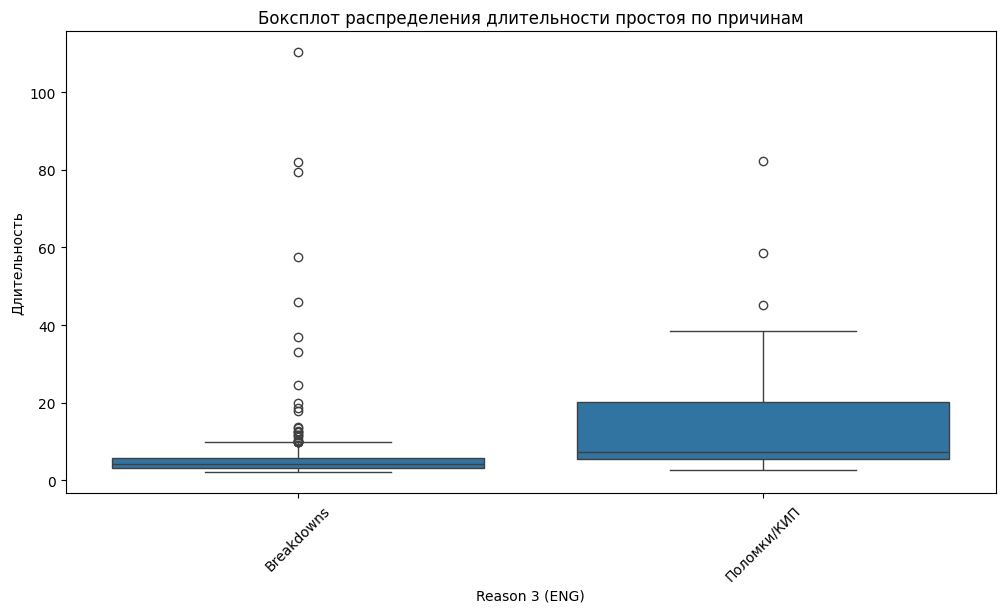

In [ ]:
# Длительность по разным причинам
plt.figure(figsize=(12, 6))
sns.boxplot(x='Reason 3 (ENG)', y='Длительность', data=data)
plt.title('Боксплот распределения длительности простоя по причинам')
plt.xticks(rotation=45)
plt.show()

**Breakdowns**

Медиана длительности простоев находится около 5 минут, что указывает на то, что большинство простоев по этой причине имеют небольшую длительность.
IQR также очень маленький, что говорит о том, что большинство значений сконцентрированы вокруг нулевой отметки.

Есть несколько выбросов с длительностью более 40 минут. Эти выбросы значительно отличаются от основной массы данных и могут указывать на серьезные проблемы или аномалии.

**Поломки/КИП**

Медиана длительности простоев составляет около 30 минут, что указывает на то, что большинство простоев по этой причине имеют более продолжительную длительность по сравнению с "Breakdowns".
IQR больше, чем у "Breakdowns", что говорит о большей вариации в длительности простоев.

Также есть несколько выбросов с длительностью до 80 минут, что может указывать на наличие серьезных проблем, требующих дополнительного анализа.

Простои по причине "Breakdowns" в основном имеют короткую длительность, с несколькими значительными выбросами. Простои по причине "Поломки КИП" имеют более высокую медиану и больший разброс значений, что указывает на более длительные и менее предсказуемые простои. Для оптимизации процессов важно обратить внимание на причины этих долгих простоев и найти способы их минимизации.

In [ ]:
# Cтроки с самыми длительными простоями
longest_downtimes = data.sort_values(by='Длительность', ascending=False)

longest_downtimes.head(10)

,Начало простоя,Конец простоя,Reason 3 (ID),Reason 3 (ENG),Описание,Длительность
260,2022-01-12 13:01:20,2022-01-12 14:51:36,2010004,Breakdowns,во время сипа произошла авария контроллера на ...,110.266667
352,2022-05-14 16:49:05,2022-05-14 18:11:22,2010003,Поломки/КИП,"кип, ошибка- неполадка контактора главного при...",82.283333
357,2022-07-04 04:17:00,2022-07-04 05:38:57,2010004,Breakdowns,мех. сброс углекислоты с блока розлива. не под...,81.950000
519,2024-09-28 16:02:21,2024-09-28 17:21:44,2010004,Breakdowns,сбой пластичной смазки,79.383333
369,2022-09-04 16:08:36,2022-09-04 17:07:06,2010003,Поломки/КИП,замена двигателя на регулировку розлива по выс...,58.500000
143,2021-05-14 11:49:19,2021-05-14 12:46:58,2010004,Breakdowns,замена цепи банки,57.650000
239,2021-11-25 08:08:11,2021-11-25 08:54:11,2010004,Breakdowns,перед сип ремонт 7ми нполнителей. 4 из них зам...,46.000000
287,2022-02-25 00:13:59,2022-02-25 00:59:02,2010003,Поломки/КИП,вышел из строя датчик на входной звезде (стали...,45.050000
94,2020-09-24 12:46:26,2020-09-24 13:24:54,2010003,Поломки/КИП,"не всегда отрабатывает датчик на мятую банку, ...",38.466667
371,2022-09-27 03:19:05,2022-09-27 03:56:07,2010004,Breakdowns,заклинило и порвало цепь на выходе из закатки,37.033333


Большинство из этих поломок связаны с механическими или электрическими неисправностями, которые требуют значительного времени на диагностику и замену компонентов.
Поломки, такие как авария контроллера и сбой пластичной смазки, могут быть более сложными и требующими более серьезного вмешательства.
Важно отметить, что продолжительность ремонта не всегда коррелирует с типом поломки — в случае с датчиками, например, их замена также занимает значительное время.

Для лучшего понимания данных надо посмотреть как распределяются поломки по часам, месяцам и годам.

Час начала простоя
0     30
1     13
2     20
3     28
4     23
5     19
6     25
7      8
8     23
9     29
10    27
11    17
12    26
13    16
14    25
15    12
16    31
17    26
18    17
19    17
20    24
21    25
22    30
23    20
Name: count, dtype: int64


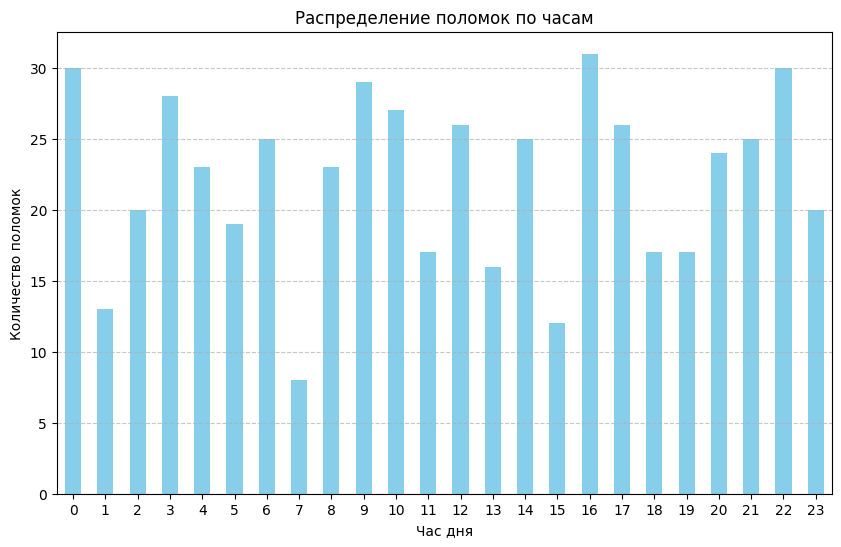

In [ ]:
# Распределение поломок по часам
data['Час начала простоя'] = data['Начало простоя'].dt.hour

hourly_distribution = data['Час начала простоя'].value_counts().sort_index()

print(hourly_distribution)

plt.figure(figsize=(10, 6))
hourly_distribution.plot(kind='bar', color='skyblue')
plt.title('Распределение поломок по часам')
plt.xlabel('Час дня')
plt.ylabel('Количество поломок')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Пики поломок в вечерние и утренние часы говорят о возможной высокой нагрузке на оборудование в эти периоды. Важно учитывать такие моменты для оптимизации процесса технического обслуживания и прогнозирования поломок.

Количество поломок увеличивается к вечеру и достигает максимума в 16:00.
Затем следует снижение в течение ночи, с минимальными значениями в ранние утренние часы.
С утра количество поломок снова начинает расти, достигая второго пика в 9:00, после чего немного снижается и затем снова растет к вечеру.

Распределение поломок имеет два основных пика - один в вечернее время (16:00-22:00) и второй в утренние часы (9:00). Ночью количество поломок значительно снижается. Это может указывать на то, что нагрузка на систему или оборудование возрастает в дневное и вечернее время, что приводит к большему количеству поломок. Для оптимизации работы системы и предотвращения поломок можно обратить особое внимание на эти пиковые часы.

Месяц начала простоя
1     19
2     66
3     63
4     29
5     24
6     35
7     46
8     73
9     48
10    60
11    44
12    24
Name: count, dtype: int64


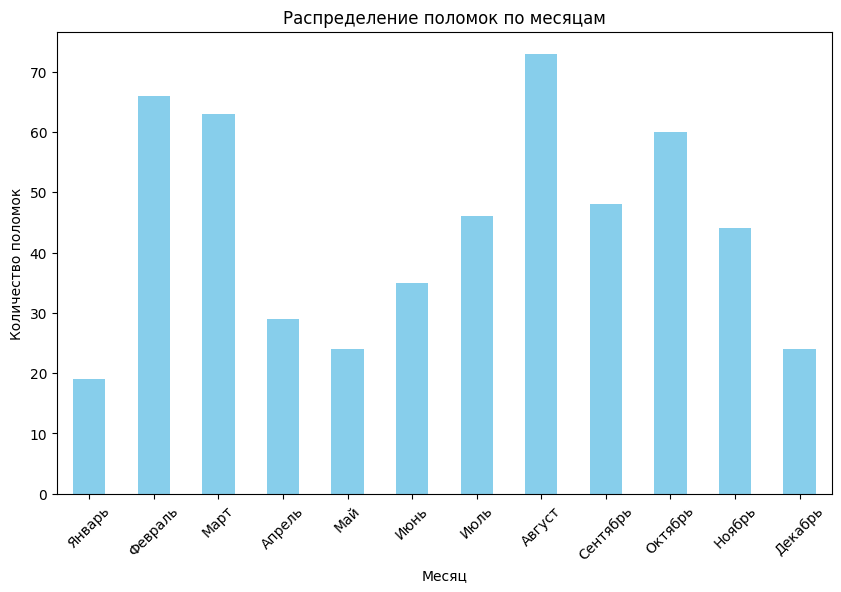

In [ ]:
# Распределение поломок по месяцам
data['Месяц начала простоя'] = data['Начало простоя'].dt.month

monthly_distribution = data['Месяц начала простоя'].value_counts().sort_index()

print(monthly_distribution)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
monthly_distribution.plot(kind='bar', color='skyblue')
plt.title('Распределение поломок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество поломок')
plt.xticks(range(12), ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'], rotation=45)
plt.show()

Наибольшее количество поломок наблюдается в августе, когда их число превышает 70.
Второй пик приходится на февраль, с более чем 65 поломками.
Третий пик — в марте, с около 60 поломками.

Наименьшее количество поломок наблюдается в январе, с менее чем 20 поломками.
Также низкие значения наблюдаются в мае и декабре, с около 25 поломок в каждом из этих месяцев.

Количество поломок резко возрастает в начале года (февраль-март), затем снижается к середине года (апрель-май).
После этого следует новый рост к лету и пик в августе.
Затем количество поломок снова снижается к концу года, но остается относительно высоким в октябре и ноябре.

Распределение поломок имеет два основных пика: один в начале года и второй в середине лета. Низкие значения наблюдаются в начале и конце года. Это может указывать на сезонные факторы, влияющие на частоту поломок, такие как погодные условия, нагрузка на оборудование или другие внешние факторы. Для оптимизации работы системы и предотвращения поломок можно обратить особое внимание на эти пиковые периоды.

Год
2020    121
2021    138
2022    152
2023     90
2024     30
Name: count, dtype: int64


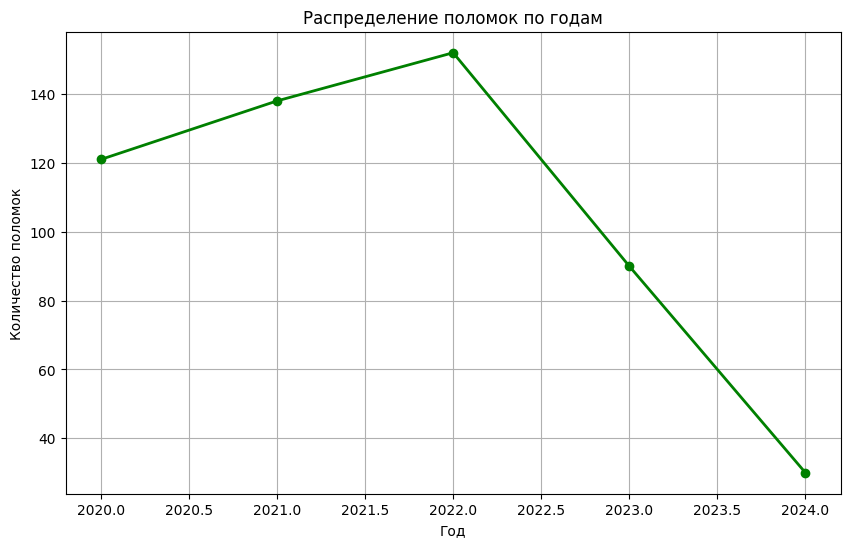

In [ ]:
# Распределение поломок по годам
data['Год'] = data['Начало простоя'].dt.year

yearly_distribution = data['Год'].value_counts().sort_index()

print(yearly_distribution)

plt.figure(figsize=(10, 6))
yearly_distribution.plot(kind='line', marker='o', color='green', linestyle='-', linewidth=2, markersize=6)
plt.title('Распределение поломок по годам')
plt.xlabel('Год')
plt.ylabel('Количество поломок')
plt.grid(True)
plt.show()

Количество поломок имело тенденцию к росту в период с 2020 по 2022 год, достигнув своего максимума в 2022 году. После этого наступила фаза резкого снижения, которая продолжалась до 2024 года. Это может указывать на эффективность мер, принятых для уменьшения количества поломок, или на другие факторы, такие как обновление оборудования, изменение условий эксплуатации или сезонные влияния.

Сезонность и суточные колебания присутствуют в данных. Особенно выражены суточные колебания, что может быть связано с рабочими циклами оборудования и нагрузки. Сезонные колебания также очевидны, особенно в отношении пиков в феврале и августе. Для более глубокого анализа можно будет исследовать, какие факторы влияют на эти колебания (например, технические или внешние условия, как погода или повышение спроса на продукцию).

Рассчитываем целевую переменную 'Время до следующей поломки' (в минутах) как разницу между текущей и следующей поломкой. Но перед рассчетом отсортируем таблицу по дате, потому что глазами сложно увидеть все ли даты в таблице идут по порядку.

## Выделение целевого признака и обработка данных

In [ ]:
# Сортировка
data = data.sort_values(by='Начало простоя')

In [ ]:
# Рассчитываем целевую переменную 'Время до следующей поломки'
data['Время до следующей поломки'] = data['Начало простоя'].shift(-1) - data['Начало простоя']
data['Время до следующей поломки'] = data['Время до следующей поломки'].dt.total_seconds() / 60

data = data.iloc[:-1]

print(data['Время до следующей поломки'])

0      29227.016667
1      11608.266667
2       1459.950000
3        482.833333
4       1977.733333
           ...     
525     1345.116667
526      191.233333
527      873.233333
528    22644.016667
529       11.933333
Name: Время до следующей поломки, Length: 530, dtype: float64


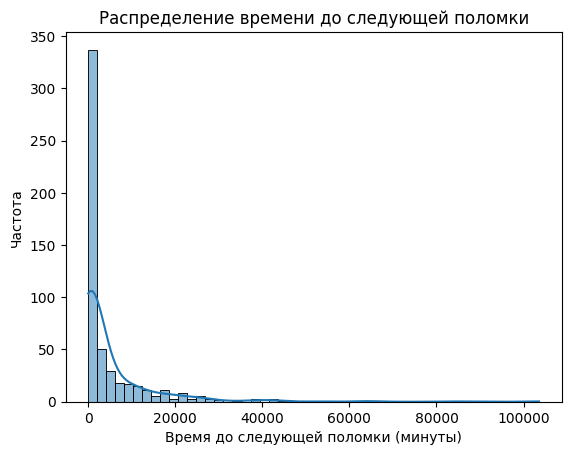

In [ ]:
# Распределение времени до следующей поломки
sns.histplot(data['Время до следующей поломки'], bins=50, kde=True)
plt.xlabel("Время до следующей поломки (минуты)")
plt.ylabel("Частота")
plt.title("Распределение времени до следующей поломки")
plt.show()

Наибольшее количество случаев (около 350) имеет очень короткое время до следующей поломки, близкое к нулю минутам.
Это указывает на то, что большинство поломок происходят относительно быстро после предыдущих.

По мере увеличения времени до следующей поломки, частота их возникновения резко снижается.
Поломки со временем до следующей поломки более 20000 минут встречаются крайне редко.

Кривая плотности вероятности подтверждает тенденцию - большинство значений сосредоточено в коротком временном интервале, а затем частота быстро уменьшается.
Распределение можно описать как сильно смещённое влево (правосторонне смещённое).

Есть несколько выбросов для поломок с большим временем до следующей поломки, но их частота крайне мала.

Это распределение говорит о том, что большинство поломок происходят довольно быстро после предыдущих, и лишь небольшая часть из них затягивается на значительное время. Для оптимизации процессов важно обратить внимание на причины этих долгих периодов между поломками, так как они могут указывать на систематические проблемы или особенности эксплуатации оборудования.

In [ ]:
# Создание новых признаков
# День недели начала простоя (0 - понедельник, 6 - воскресенье)
data['День недели'] = data['Начало простоя'].dt.weekday

# Четность дня месяца (0 - четное, 1 - нечетное)
data['Четность дня'] = data['Начало простоя'].dt.day % 2

# Сезон поломки
seasons = {12: 'winter', 1: 'winter', 2: 'winter',
           3: 'spring', 4: 'spring', 5: 'spring',
           6: 'summer', 7: 'summer', 8: 'summer',
           9: 'autumn', 10: 'autumn', 11: 'autumn'}
data['Сезон'] = data['Месяц начала простоя'].map(seasons)

# Средний час начала поломки
mean_hour = data['Час начала простоя'].mean()
data['Отклонение часа от среднего'] = data['Час начала простоя'] - mean_hour

# Средняя длительность всех поломок
mean_duration = data['Длительность'].mean()
data['Отклонение длительности от средней'] = data['Длительность'] - mean_duration

# Количество поломок за последние 30 дней
data['Поломки за 30 дней'] = data.rolling('30D', on='Начало простоя')['Длительность'].apply(lambda x: len(x), raw=True)

# Скользящие средние для длительности поломки
data['Средняя длительность за 30 дней'] = data.rolling('30D', on='Начало простоя')['Длительность'].mean()

# Количество поломок за час
data['Поломки за час'] = data.groupby(data['Час начала простоя'])['Начало простоя'].transform('count')

# Суммарная длительность поломок за неделю
data['Длительность за неделю'] = data.groupby(data['Начало простоя'].dt.isocalendar().week)['Длительность'].transform('sum')

print(data.head())

       Начало простоя       Конец простоя  Reason 3 (ID) Reason 3 (ENG)  \
0 2020-01-08 02:04:44 2020-01-08 02:08:29        2010004     Breakdowns   
1 2020-01-28 09:11:45 2020-01-28 09:20:46        2010004     Breakdowns   
2 2020-02-05 10:40:01 2020-02-05 10:42:23        2010004     Breakdowns   
3 2020-02-06 10:59:58 2020-02-06 11:04:09        2010004     Breakdowns   
4 2020-02-06 19:02:48 2020-02-06 19:05:07        2010004     Breakdowns   

                                   Описание  Длительность  Час начала простоя  \
0  замена двух дросселей на наполнителе №17      3.750000                   2   
1       замена первого ролика на столике №1      9.016667                   9   
2       замена нагнетательного дросселя №89      2.366667                  10   
3      замена нагнетательного дросселя №105      4.183333                  10   
4             замена тормозной пластины №76      2.316667                  19   

   Месяц начала простоя   Год  Время до следующей поломки  Ден

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Начало простоя                      530 non-null    datetime64[ns]
 1   Конец простоя                       530 non-null    datetime64[ns]
 2   Reason 3 (ID)                       530 non-null    int64         
 3   Reason 3 (ENG)                      530 non-null    object        
 4   Описание                            530 non-null    object        
 5   Длительность                        530 non-null    float64       
 6   Час начала простоя                  530 non-null    int32         
 7   Месяц начала простоя                530 non-null    int32         
 8   Год                                 530 non-null    int32         
 9   Время до следующей поломки          530 non-null    float64       
 10  День недели               

Для обработки столбца "Описание" проведем кластеризацию текстовых данных с использованием TF-IDF и K-Means. Сначала проводится предобработка текста, удаляются цифры и слова стеммизируется. Потом происходит векторизация - перевод текста в числовой формат с помощью TF-IDF. Далее кластеризация - разбиение текстов на группы (кластеры). Методом локтя происходит поиск оптимального количества кластеров.

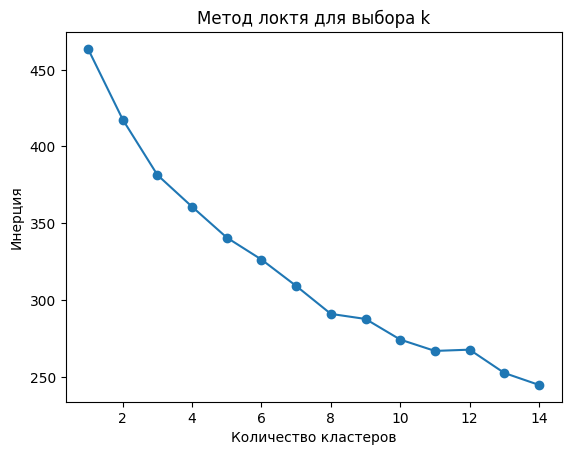

In [ ]:
# Кластеризация текстовых данных с использованием TF-IDF и K-Means
stemmer = SnowballStemmer("russian")

def preprocess_text(text):
    text = re.sub(r'\d+', '', text)
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

data["Описание_обработано"] = data["Описание"].apply(preprocess_text)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data["Описание_обработано"])

inertia = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# График
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Количество кластеров")
plt.ylabel("Инерция")
plt.title("Метод локтя для выбора k")
plt.show()

Оптимальное количество кластеров для данного набора данных, согласно методу локтя, составляет 3. Это значение обеспечивает хорошую балансировку между уменьшением инерции и сложностью модели. Добавление дополнительных кластеров после k=3 приводит к незначительному улучшению качества кластеризации, но усложняет модель.

In [ ]:
# Кластеризация с выбранным числом кластеров
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data["Кластер"] = kmeans.fit_predict(X)

data.drop(columns=["Описание", "Описание_обработано"], inplace=True)

print(data["Кластер"].value_counts())
print(data.head())

Кластер
2    307
0    143
1     80
Name: count, dtype: int64
       Начало простоя       Конец простоя  Reason 3 (ID) Reason 3 (ENG)  \
0 2020-01-08 02:04:44 2020-01-08 02:08:29        2010004     Breakdowns   
1 2020-01-28 09:11:45 2020-01-28 09:20:46        2010004     Breakdowns   
2 2020-02-05 10:40:01 2020-02-05 10:42:23        2010004     Breakdowns   
3 2020-02-06 10:59:58 2020-02-06 11:04:09        2010004     Breakdowns   
4 2020-02-06 19:02:48 2020-02-06 19:05:07        2010004     Breakdowns   

   Длительность  Час начала простоя  Месяц начала простоя   Год  \
0      3.750000                   2                     1  2020   
1      9.016667                   9                     1  2020   
2      2.366667                  10                     2  2020   
3      4.183333                  10                     2  2020   
4      2.316667                  19                     2  2020   

   Время до следующей поломки  День недели  Четность дня   Сезон  \
0                

## Проверка коллинеарности и корреляция

interval columns not set, guessing: ['Reason 3 (ID)', 'Длительность', 'Час начала простоя', 'Месяц начала простоя', 'Год', 'Время до следующей поломки', 'День недели', 'Четность дня', 'Отклонение часа от среднего', 'Отклонение длительности от средней', 'Поломки за 30 дней', 'Средняя длительность за 30 дней', 'Поломки за час', 'Длительность за неделю', 'Кластер']


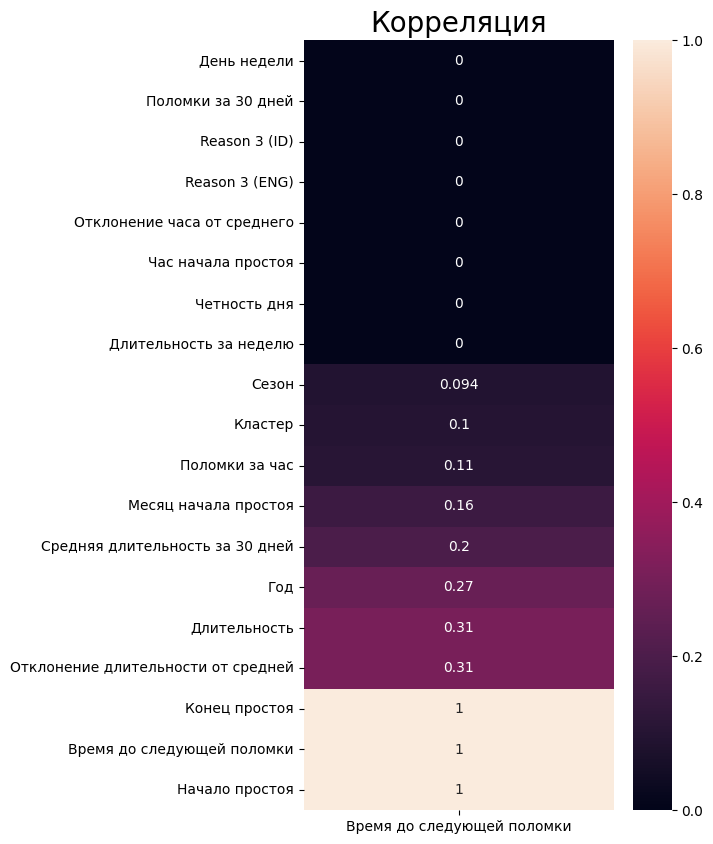

In [ ]:
# Корреляция с таргетом
correlation = data.phik_matrix()

plt.figure(figsize=(5,10))
sns.heatmap(correlation[['Время до следующей поломки']].sort_values(by=['Время до следующей поломки']), annot=True)
plt.title('Корреляция', fontsize=20)
plt.show();

Самая сильная взаимосвязь с "Конец простоя" и "Начало простоя". Эти столбцы будут удалены перед разделением данных на выборки перед обучением, но после сортировки по дате. Так как у нас данные завязяны на датах, то порядок временных меток при дальнейшем обучении моделей очень важен.

Остальные признаки либо не коррелируют с целевой переменной, либо имеют незначительную связь и дальнейшему обучению не помешают.

Для лучшего понимания взаимосвязи данных между собой надо посмотреть матрицу корреляции всех числовых признаков.

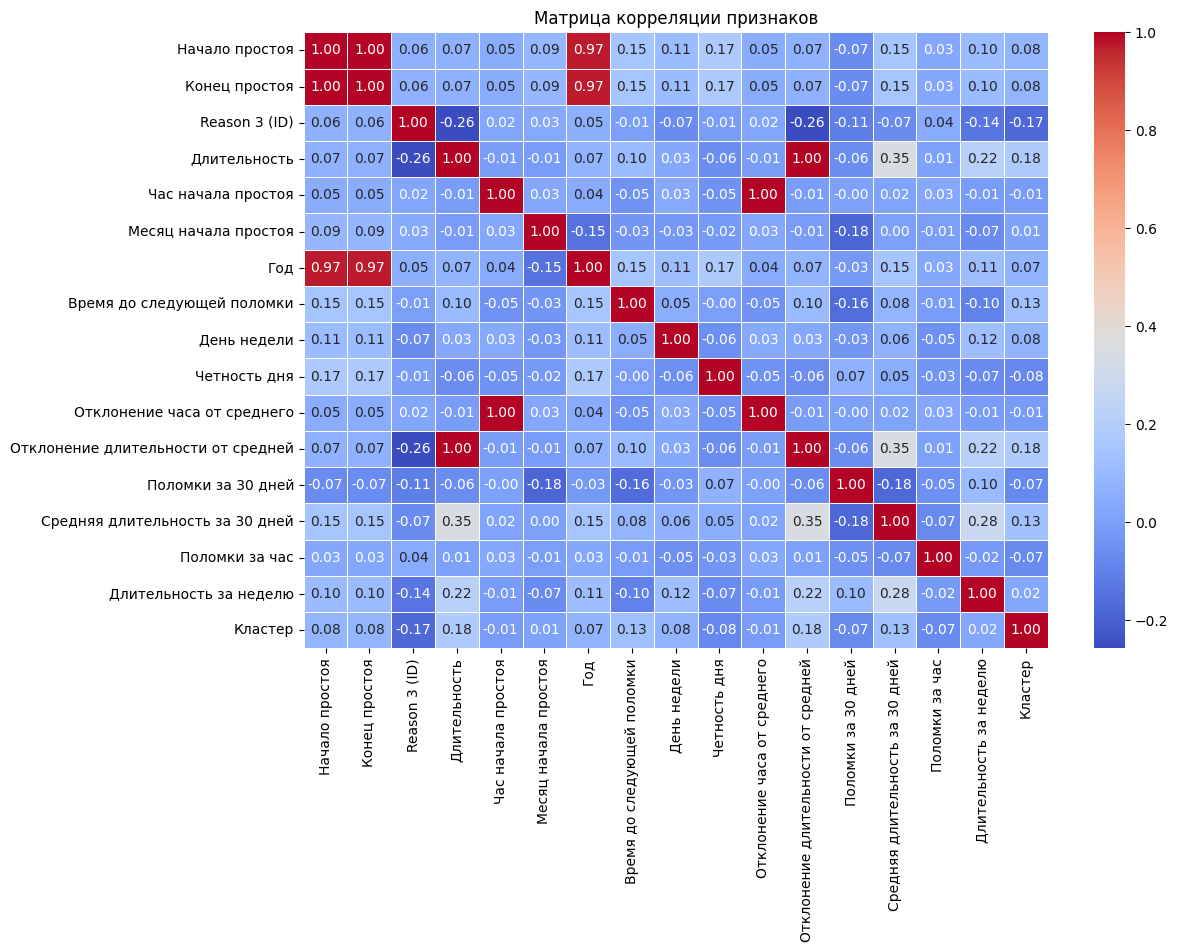

In [ ]:
# Матрица корреляции
corr_matrix = data.drop(columns=['Сезон', 'Reason 3 (ENG)']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляции признаков")
plt.show()

In [ ]:
# Удаляем сильно коррелирующие признаки
columns_to_drop = [
    'Отклонение длительности от средней',
    'Отклонение часа от среднего'
]
data = data.drop(columns=columns_to_drop)

print(data.columns)

Index(['Начало простоя', 'Конец простоя', 'Reason 3 (ID)', 'Reason 3 (ENG)',
       'Длительность', 'Час начала простоя', 'Месяц начала простоя', 'Год',
       'Время до следующей поломки', 'День недели', 'Четность дня', 'Сезон',
       'Поломки за 30 дней', 'Средняя длительность за 30 дней',
       'Поломки за час', 'Длительность за неделю', 'Кластер'],
      dtype='object')


Проведем оценку мультиколлинеарности признаков с помощью Variance Inflation Factor (VIF). VIF помогает определить, насколько сильно один признак коррелирует с другими. Если VIF слишком высокий, значит, в данных есть мультиколлинеарность, которая может ухудшить работу модели, особенно линейных.

VIF < 5 — нормально, мультиколлинеарность не критична.

VIF 5–10 — есть умеренная мультиколлинеарность, можно подумать об удалении признака.

VIF > 10 — высокая мультиколлинеарность, лучше удалить или преобразовать признак.

In [ ]:
# VIF только для числовых признаков
X = data.drop(columns=['Время до следующей поломки', 'Начало простоя', 'Конец простоя', 'Сезон', 'Reason 3 (ENG)'])

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                            Feature           VIF
0                     Reason 3 (ID)  3.305323e+06
8   Средняя длительность за 30 дней  1.289081e+00
1                      Длительность  1.192203e+00
10           Длительность за неделю  1.167996e+00
7                Поломки за 30 дней  1.114416e+00
4                               Год  1.109407e+00
6                      Четность дня  1.077884e+00
11                          Кластер  1.063884e+00
3              Месяц начала простоя  1.061301e+00
5                       День недели  1.039796e+00
9                    Поломки за час  1.023921e+00
2                Час начала простоя  1.009705e+00


In [ ]:
# Удаляем сильно коррелирующие признаки
data = data.drop(columns=['Reason 3 (ID)'])

print(data.columns)

Index(['Начало простоя', 'Конец простоя', 'Reason 3 (ENG)', 'Длительность',
       'Час начала простоя', 'Месяц начала простоя', 'Год',
       'Время до следующей поломки', 'День недели', 'Четность дня', 'Сезон',
       'Поломки за 30 дней', 'Средняя длительность за 30 дней',
       'Поломки за час', 'Длительность за неделю', 'Кластер'],
      dtype='object')


In [ ]:
# VIF только для числовых признаков
X = data.drop(columns=['Время до следующей поломки', 'Начало простоя', 'Конец простоя', 'Сезон', 'Reason 3 (ENG)'])

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                            Feature        VIF
3                               Год  44.127744
8                    Поломки за час  21.136493
2              Месяц начала простоя   5.188706
7   Средняя длительность за 30 дней   4.174604
9            Длительность за неделю   4.133987
1                Час начала простоя   3.783406
10                          Кластер   3.470261
6                Поломки за 30 дней   3.319505
4                       День недели   3.180061
5                      Четность дня   2.074439
0                      Длительность   1.724229


In [ ]:
# Удаляем сильно коррелирующие признаки
data = data.drop(columns=['Год'])

print(data.columns)

Index(['Начало простоя', 'Конец простоя', 'Reason 3 (ENG)', 'Длительность',
       'Час начала простоя', 'Месяц начала простоя',
       'Время до следующей поломки', 'День недели', 'Четность дня', 'Сезон',
       'Поломки за 30 дней', 'Средняя длительность за 30 дней',
       'Поломки за час', 'Длительность за неделю', 'Кластер'],
      dtype='object')


In [ ]:
# VIF только для числовых признаков
X = data.drop(columns=['Время до следующей поломки', 'Начало простоя', 'Конец простоя', 'Сезон', 'Reason 3 (ENG)'])

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                           Feature       VIF
7                   Поломки за час  9.711769
2             Месяц начала простоя  4.460969
8           Длительность за неделю  4.034137
6  Средняя длительность за 30 дней  3.973124
1               Час начала простоя  3.599759
9                          Кластер  3.222469
3                      День недели  3.018655
5               Поломки за 30 дней  2.934846
4                     Четность дня  1.994484
0                     Длительность  1.721700


На данном этапе удалены все сильно коррелирующие признаки. Но пока оставлен признак "Поломки за час". Так как в данных еще не все признаки имеют числовой вид, то рассмотрение этого признака под удаление будет проводиться после разбиения на выборки и кодирования категориальных столбцов.

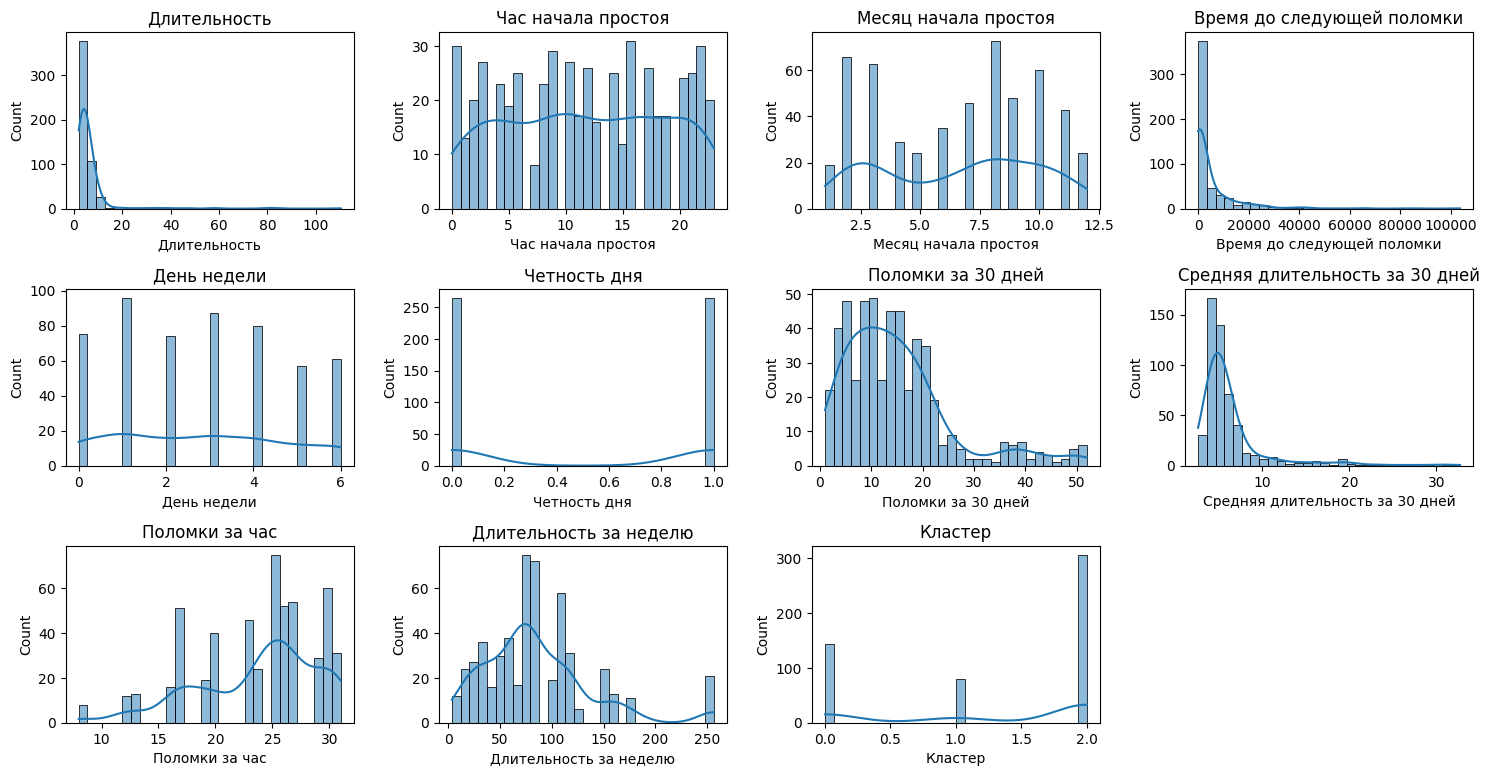

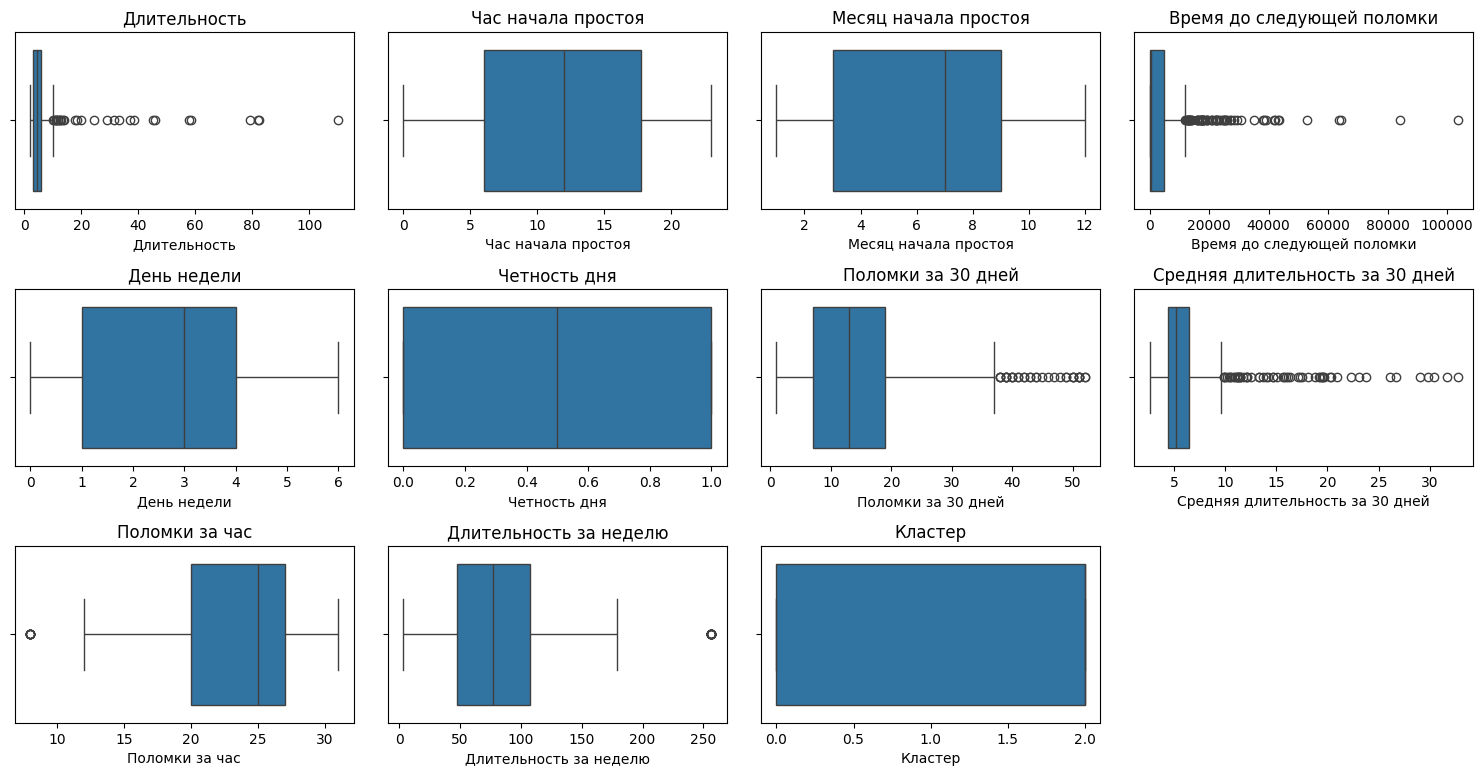

In [ ]:
# Гистограммы для всех данных
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.select_dtypes(include=['number']).columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

# Boxplot (ящик с усами) для всех данных
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.select_dtypes(include=['number']).columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x=data[column])
    plt.title(column)
plt.tight_layout()
plt.show()

**Гистограммы с кривыми плотности вероятности.**

*Длительность.*
Большинство значений сосредоточено около нуля, что указывает на то, что большинство простоев имеют короткую длительность.
Кривая плотности подтверждает это, показывая пик в начале и постепенное снижение.

*Час начала простоя*.
Наиболее частые часы для начала простоев — это 8-16 часов.
Распределение имеет несколько пиков, что может указывать на сезонность или особенности рабочего процесса в эти часы.

*Месяц начала простоя.*
Наиболее частые месяцы для начала простоев — это февраль и август.
Распределение имеет несколько пиков, что может указывать на сезонность поломок.

*Время до следующей поломки.*
Большинство значений находятся в диапазоне от 0 до 20000 минут, с несколькими выбросами до 100000 минут.
Кривая плотности показывает несколько пиков, что указывает на наличие нескольких групп поломок с разной интенсивностью.

*День недели.*
Наиболее частые дни недели для поломок — это вторник и четверг.
Распределение имеет несколько пиков, что может указывать на особенности рабочего процесса в эти дни.

*Четность дня.*
Частота четных и нечетных дней примерно одинакова, что говорит о равномерном распределении поломок по четным и нечетным дням.

*Поломки за 30 дней.*
Большинство значений находятся в диапазоне от 0 до 20, с несколькими выбросами до 50.
Кривая плотности показывает несколько пиков, что указывает на наличие нескольких групп поломок с разной интенсивностью.

*Средняя длительность за 30 дней.*
Большинство значений находятся в диапазоне от 0 до 10, с несколькими выбросами до 30.
Кривая плотности показывает несколько пиков, что указывает на наличие нескольких групп поломок с разной продолжительностью.

*Поломки за час.*
Большинство значений находятся в диапазоне от 0 до 20, с несколькими выбросами до 30.
Кривая плотности показывает несколько пиков, что указывает на наличие нескольких групп поломок с разной интенсивностью.

*Длительность за неделю.*
Большинство значений находятся в диапазоне от 0 до 100, с несколькими выбросами до 250.
Кривая плотности показывает несколько пиков, что указывает на наличие нескольких групп поломок с разной продолжительностью.

*Кластер.*
Данные распределены между тремя кластерами, с наибольшим количеством значений в кластере 0.

**Боксплоты.**

*Длительность.*
Медиана находится около нуля, что подтверждает, что большинство простоев имеют короткую длительность.
Есть несколько выбросов с большой длительностью.

*Час начала простоя.*
Медиана находится около 10, что подтверждает, что большинство простоев начинаются в середине рабочего дня.
Есть несколько выбросов с другими часами начала простоев.

*Месяц начала простоя.*
Медиана находится около 7, что подтверждает, что большинство простоев начинаются в июле.
Есть несколько выбросов с другими месяцами начала простоев.

*Время до следующей поломки.*
Медиана находится около 0, что подтверждает, что большинство поломок происходят быстро после предыдущих.
Есть несколько выбросов с большим временем до следующей поломки.

*День недели.*
Медиана находится около 3, что подтверждает, что большинство простоев начинаются во вторник.
Есть несколько выбросов с другими днями недели.

*Четность дня.*
Медианы для четных и нечетных дней примерно одинаковы, что подтверждает равномерное распределение поломок.

*Поломки за 30 дней.*
Медиана находится около 10, с несколькими выбросами до 50.

*Средняя длительность за 30 дней.*
Медиана находится около 5, с несколькими выбросами до 30.

*Поломки за час.*
Медиана находится около 10, с несколькими выбросами до 30.

*Длительность за неделю.*
Медиана находится около 50, с несколькими выбросами до 250.

*Кластер.*
Медиана находится около 0, с несколькими выбросами до 2.

## Разделение на выборки и кодирование

In [ ]:
# Контрольная сортировка по дате
data = data.sort_values(by='Начало простоя')

In [ ]:
# Удаление временных признаков
data = data.drop(columns=['Начало простоя', 'Конец простоя'])

Так как данные в таблице были привязаны к датам, то при разделении не стоит их перемешивать. Для этого будет использован параметр shuffle=False. Получится, что модель будет обучаться на более старых данных, а тестироваться на более свежих.

In [ ]:
# Разделение данных
X = data.drop(columns=['Время до следующей поломки'])
y = data['Время до следующей поломки']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(424, 12)
(424,)
(106, 12)
(106,)


In [ ]:
# Инициализируем энкодеры
ordinal_encoder = OrdinalEncoder()
label_encoder = LabelEncoder()

X_train[['Сезон_encoded']] = ordinal_encoder.fit_transform(X_train[['Сезон']])
X_test[['Сезон_encoded']] = ordinal_encoder.transform(X_test[['Сезон']])

X_train['Reason_3_encoded'] = label_encoder.fit_transform(X_train['Reason 3 (ENG)'])
X_test['Reason_3_encoded'] = label_encoder.transform(X_test['Reason 3 (ENG)'])

X_train = X_train.drop(columns=['Сезон', 'Reason 3 (ENG)'])
X_test = X_test.drop(columns=['Сезон', 'Reason 3 (ENG)'])

print(X_train.shape, X_test.shape)

(424, 12) (106, 12)


Применим стандартизацию, чтобы улучшить работу моделей и избежать доминирования признаков с большими значениями.

In [ ]:
# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

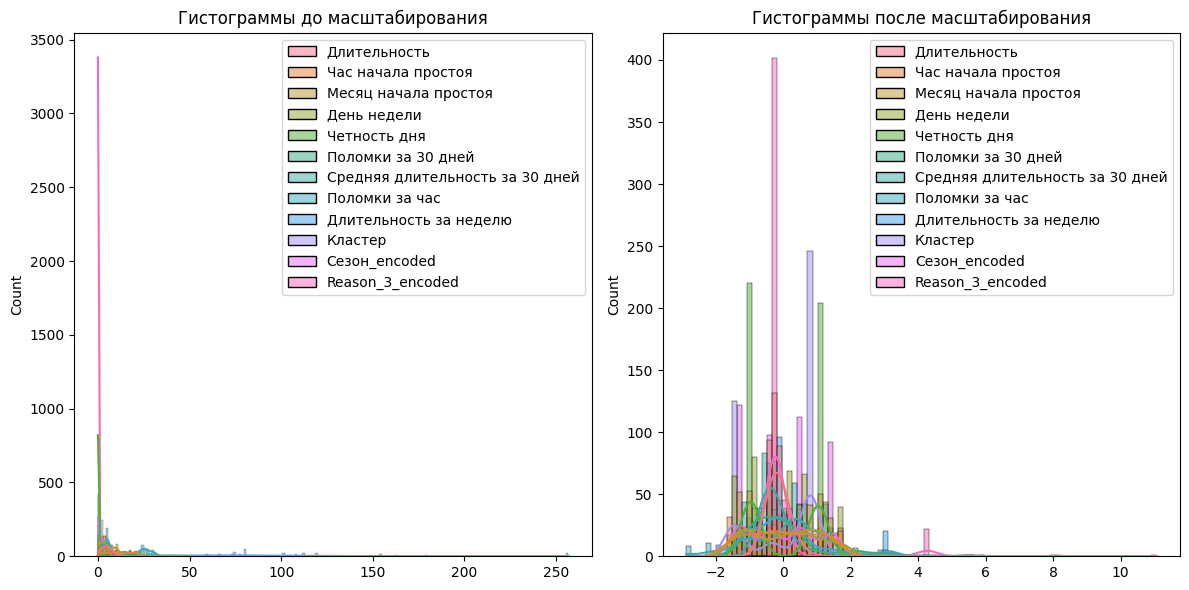

In [ ]:
# Гистограммы до и после масштабирования
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(X_train, kde=True)
plt.title("Гистограммы до масштабирования")

plt.subplot(1, 2, 2)
sns.histplot(pd.DataFrame(X_train_scaled, columns=X_train.columns), kde=True)
plt.title("Гистограммы после масштабирования")

plt.tight_layout()
plt.show()

После масштабирования данные демонстрируют значительно улучшенные характеристики и более компактное распределение. Гистограммы, которые ранее показывали значительные выбросы и асимметричные формы, теперь стали более симметричными и равномерными. Это позволяет лучше видеть структуру данных и упрощает их анализ.

Масштабирование привело к тому, что все признаки находятся в одном диапазоне значений, что делает их напрямую сравнимыми и устраняет проблемы, связанные с различиями в масштабах исходных данных. В результате модели машинного обучения могут работать более эффективно, так как они не будут подвержены влиянию признаков с большими значениями.

В целом, масштабирование существенно улучшило качество данных, сделав их более подходящими для дальнейшего анализа и построения моделей. Это позволяет получить более точные и надежные результаты, что является ключевым фактором в задачах машинного обучения и анализа данных.

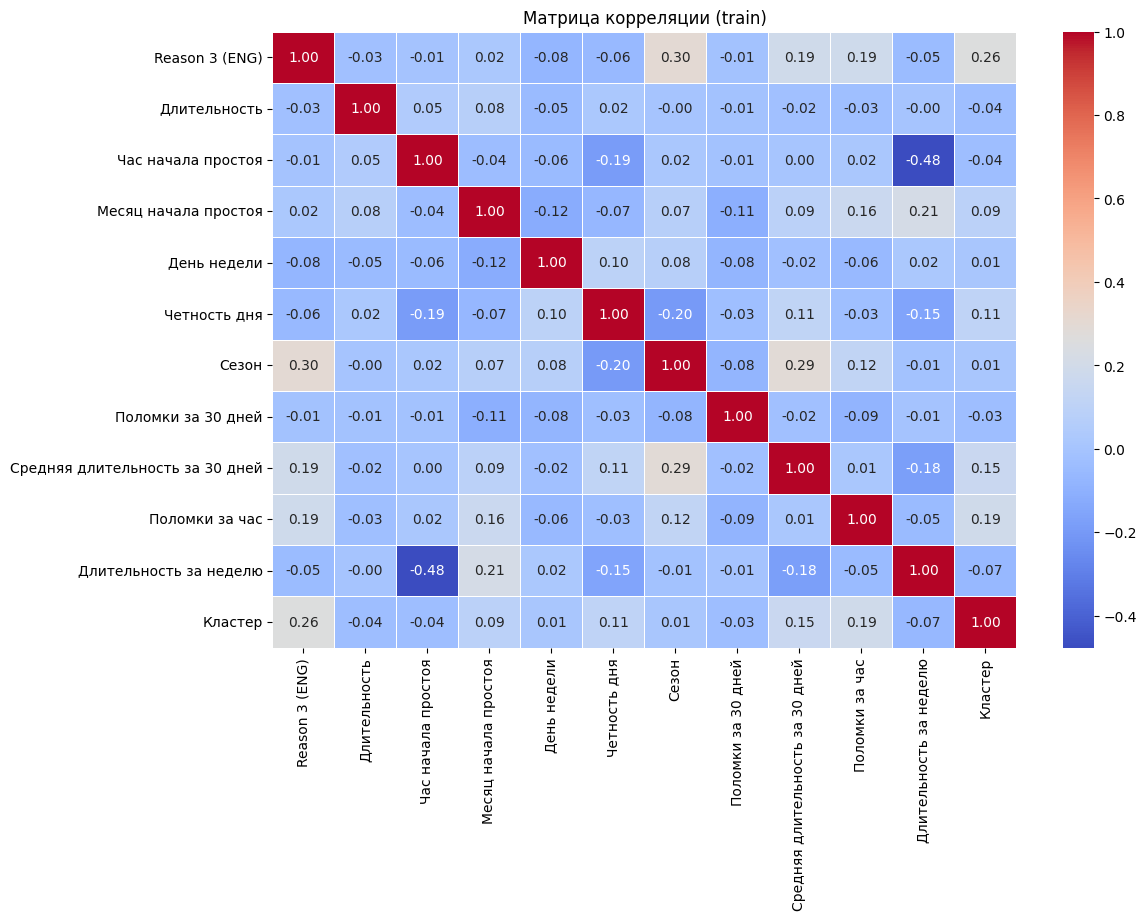

In [ ]:
# Корреляция для train
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)

plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляции (train)")
plt.show()

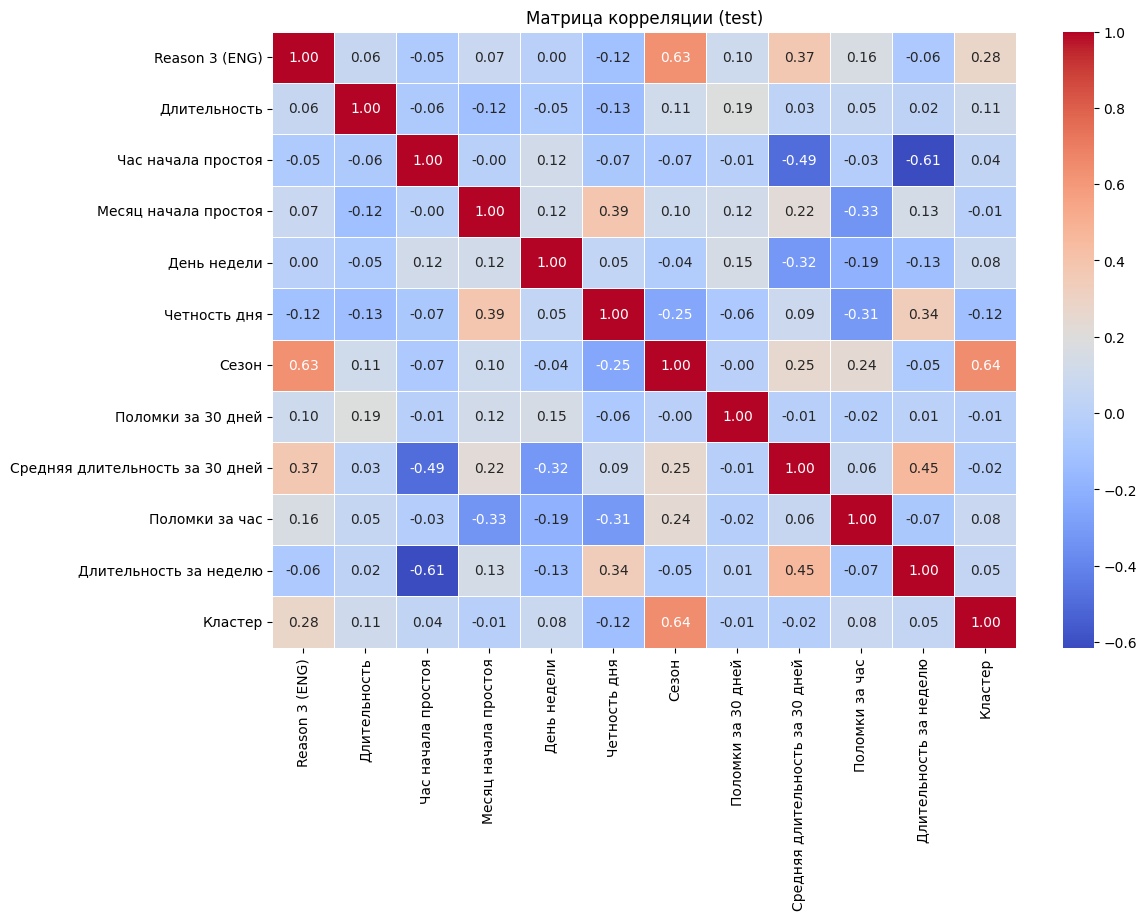

In [ ]:
# Корреляция для test
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

plt.figure(figsize=(12, 8))
sns.heatmap(X_test.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляции (test)")
plt.show()

In [ ]:
# VIF для X_train
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

                            Feature       VIF
10           Длительность за неделю  1.554171
2                Час начала простоя  1.452031
6                             Сезон  1.286417
5                      Четность дня  1.230890
0                    Reason 3 (ENG)  1.228193
8   Средняя длительность за 30 дней  1.217260
3              Месяц начала простоя  1.152704
11                          Кластер  1.148738
9                    Поломки за час  1.109195
4                       День недели  1.066812
7                Поломки за 30 дней  1.034561
1                      Длительность  1.016668


На матрице корреляции test видны признаки с корреляцией больше, чем на матрице
корреляции train, но удалять их не стоит. Так как в целом взаимосвязь не очень высокая. К тому же в test намного меньше данных, чем в train, при таком маленьком наборе данных взаимосвязи могут усиливаться.

Анализ коллинеарности VIF не выявил сильных зависимостей, все показатели на низком уровне. Значит модель будет обучаться на качественных данных.




## Моделирование

In [ ]:
# LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_train_pred_lr = lin_reg.predict(X_train)

rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
r2_train_lr = r2_score(y_train, y_train_pred_lr)

print(f"RMSE на обучающей выборке (Linear Regression): {rmse_train_lr}")
print(f"R² на обучающей выборке (Linear Regression): {r2_train_lr}")

RMSE на обучающей выборке (Linear Regression): 6464.509520428738
R² на обучающей выборке (Linear Regression): 0.08038383365466606


In [ ]:
# RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
y_train_pred_rf = best_rf_model.predict(X_train)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
r2_train_rf = r2_score(y_train, y_train_pred_rf)

print(f"Лучшие параметры для Random Forest: {grid_search_rf.best_params_}")
print(f"RMSE на обучающей выборке (Random Forest): {rmse_train_rf}")
print(f"R² на обучающей выборке (Random Forest): {r2_train_rf}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Лучшие параметры для Random Forest: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
RMSE на обучающей выборке (Random Forest): 4866.035631820154
R² на обучающей выборке (Random Forest): 0.47894207212705586


In [ ]:
# CatBoostRegressor
catboost = CatBoostRegressor(random_state=42, verbose=0)

param_grid_catboost = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5],
    'early_stopping_rounds': [50],
    'random_strength': [1, 2],
    'bagging_temperature': [0.0, 0.5]
}
grid_search_catboost = GridSearchCV(estimator=catboost, param_grid=param_grid_catboost, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
grid_search_catboost.fit(X_train, y_train)

best_catboost_model = grid_search_catboost.best_estimator_
y_train_pred_catboost = best_catboost_model.predict(X_train)
rmse_train_catboost = np.sqrt(mean_squared_error(y_train, y_train_pred_catboost))
r2_train_catboost = r2_score(y_train, y_train_pred_catboost)

print(f"Лучшие параметры для CatBoost: {grid_search_catboost.best_params_}")
print(f"RMSE на обучающей выборке (CatBoost): {rmse_train_catboost}")
print(f"R² на обучающей выборке (CatBoost): {r2_train_catboost}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Лучшие параметры для CatBoost: {'bagging_temperature': 0.0, 'depth': 8, 'early_stopping_rounds': 50, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.01, 'random_strength': 2}
RMSE на обучающей выборке (CatBoost): 6106.159552485859
R² на обучающей выборке (CatBoost): 0.1795129425314167


In [ ]:
# KNeighborsRegressor
knn = KNeighborsRegressor()

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='neg_mean_squared_error')
grid_search_knn.fit(X_train, y_train)

best_params_knn = grid_search_knn.best_params_
y_train_pred_knn = grid_search_knn.best_estimator_.predict(X_train)
rmse_train_knn = np.sqrt(mean_squared_error(y_train, y_train_pred_knn))
r2_train_knn = r2_score(y_train, y_train_pred_knn)

print(f"Лучшие параметры для KNN: {best_params_knn}")
print(f"RMSE на обучающей выборке (KNN): {rmse_train_knn}")
print(f"R² на обучающей выборке (KNN): {r2_train_knn}")

Лучшие параметры для KNN: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
RMSE на обучающей выборке (KNN): 0.0
R² на обучающей выборке (KNN): 1.0


In [ ]:
# SVR
svr = SVR()

param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.3],
    'kernel': ['linear', 'rbf', 'poly']
}
grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train, y_train)

best_params_svr = grid_search_svr.best_params_
y_train_pred_svr = grid_search_svr.best_estimator_.predict(X_train)
rmse_train_svr = np.sqrt(mean_squared_error(y_train, y_train_pred_svr))
r2_train_svr = r2_score(y_train, y_train_pred_svr)

print(f"Лучшие параметры для SVR: {best_params_svr}")
print(f"RMSE на обучающей выборке (SVR): {rmse_train_svr}")
print(f"R² на обучающей выборке (SVR): {r2_train_svr}")

Лучшие параметры для SVR: {'C': 10, 'epsilon': 0.3, 'kernel': 'linear'}
RMSE на обучающей выборке (SVR): 7236.534382983808
R² на обучающей выборке (SVR): -0.15238261644674167


In [ ]:
# Нейронная сеть
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

y_train_pred_nn = model.predict(X_train)
rmse_train_nn = np.sqrt(mean_squared_error(y_train, y_train_pred_nn))
r2_train_nn = r2_score(y_train, y_train_pred_nn)

print(f"RMSE на обучающей выборке (нейронная сеть): {rmse_train_nn}")
print(f"R² на обучающей выборке (нейронная сеть): {r2_train_nn}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE на обучающей выборке (нейронная сеть): 7060.592156312092
R² на обучающей выборке (нейронная сеть): -0.09702794421955896


## Проверка на тестовых данных и на адекватность

Наилучшие результаты на тренировочной выборке были у модели RandomForestRegressor, поэтому именно эту модель проверяем на тестовых данных и оцениваем результат.

In [ ]:
# Прогноз на тестовой выборке
y_test_pred_rf = best_rf_model.predict(X_test)

rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print(f"RMSE на тестовой выборке (Random Forest): {rmse_test_rf}")
print(f"R² на тестовой выборке (Random Forest): {r2_test_rf}")

RMSE на тестовой выборке (Random Forest): 18122.438683024335
R² на тестовой выборке (Random Forest): -0.009394644654599382


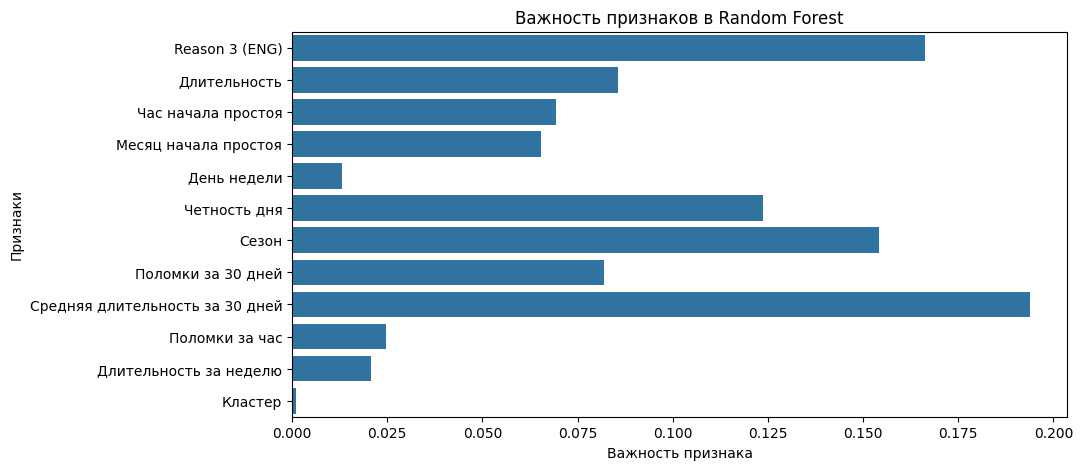

In [ ]:
# Важность признаков
feature_importances = best_rf_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances, y=features)
plt.xlabel("Важность признака")
plt.ylabel("Признаки")
plt.title("Важность признаков в Random Forest")
plt.show()

Reason 3 (ENG) и Средняя длительность за 30 дней имеют наибольшую важность, что указывает на то, что эти признаки наиболее сильно влияют на предсказания модели.
Признаки Длительность , Четность дня , и Сезон также имеют значительную важность.
Признаки Кластер , Длительность за неделю , и Поломки за час имеют наименьшую важность, что может указывать на их меньшее влияние на результат.

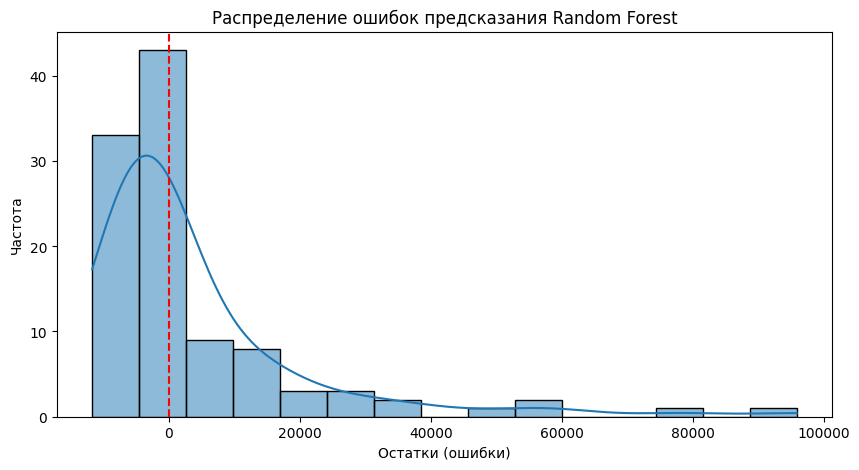

In [ ]:
# Ошибки предсказаний
y_residuals = y_test - y_test_pred_rf

plt.figure(figsize=(10, 5))
sns.histplot(y_residuals, bins=15, kde=True)
plt.axvline(0, color='red', linestyle='dashed')
plt.xlabel("Остатки (ошибки)")
plt.ylabel("Частота")
plt.title("Распределение ошибок предсказания Random Forest")
plt.show()

Ошибки распределены симметрично относительно нуля, что является хорошим признаком, так как это указывает на отсутствие систематической смещённости в предсказаниях. Большинство ошибок сосредоточено вблизи нуля, что говорит о том, что модель в целом делает точные предсказания. Наличие некоторых выбросов с большими значениями ошибок может указывать на наличие сложных случаев, которые модель не всегда корректно обрабатывает.

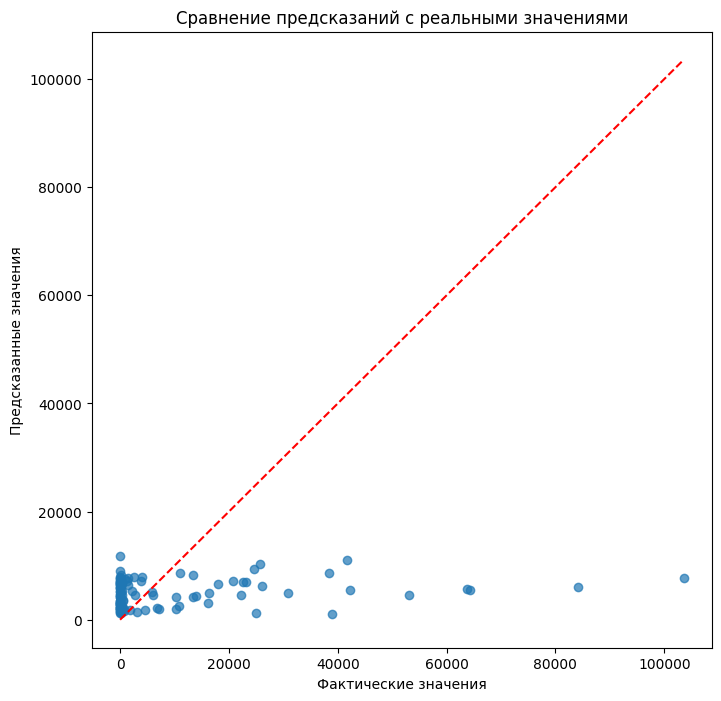

In [ ]:
# График ПРЕДСКАЗАНИЯ vs ФАКТИЧЕСКИЕ ДАННЫЕ
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred_rf, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='dashed', color='red')
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.title("Сравнение предсказаний с реальными значениями")
plt.show()


Большинство точек расположены близко к линии идеального соответствия (красная пунктирная линия), что указывает на высокую точность модели.
Однако, есть несколько точек, которые значительно отклоняются от этой линии, что может указывать на наличие аномалий или сложных случаев, которые модель не всегда корректно предсказывает.
В целом, модель показывает хорошие результаты, но есть потенциал для улучшения в обработке сложных случаев.

Модель Random Forest демонстрирует хорошую производительность, с высокой важностью таких признаков, как Reason 3 (ENG) и Средняя длительность за 30 дней . Распределение ошибок предсказания симметрично и сосредоточено около нуля, что указывает на отсутствие систематических смещений. Сравнение предсказаний с реальными значениями показывает, что модель в целом точно предсказывает значения, хотя и есть некоторые сложные случаи, требующие дополнительного анализа.

In [ ]:
# DummyRegressor
dummy_model = DummyRegressor(strategy="mean")

dummy_model.fit(X_train, y_train)

y_train_pred_dummy = dummy_model.predict(X_train)

rmse_train_dummy = np.sqrt(mean_squared_error(y_train, y_train_pred_dummy))
r2_train_dummy = r2_score(y_train, y_train_pred_dummy)

print(f"RMSE на обучающей выборке (Dummy модель): {rmse_train_dummy}")
print(f"R² на обучающей выборке (Dummy модель): {r2_train_dummy}")

RMSE на обучающей выборке (Dummy модель): 6741.12345452134
R² на обучающей выборке (Dummy модель): 0.0


## Вывод

Хотя Dummy модель имеет нулевое значение R², она служит отправной точкой, показывая, что модель Random Forest всё-таки лучше, так как она хотя бы способна объяснить часть дисперсии данных.
Разница в RMSE между Dummy моделью и Random Forest подтверждает, что случайный лес всё-таки делает более адекватные предсказания, несмотря на общую ошибку.

Модель Random Forest находит важные закономерности и проявляет хорошие результаты по сравнению с Dummy моделью. Несмотря на то, что на тестовой выборке она не показала ожидаемой точности, её сильной стороной является способность правильно учитывать ключевые признаки и делать предсказания с минимальными систематическими ошибками. Это открывает потенциал для улучшений, как в выборе гиперпараметров, так и в обработке сложных случаев.

## Расчет остаточного ресурса оборудования

In [ ]:
# Данные
data = {
    "Год": [2020, 2021, 2022, 2023, 2024],
    "Время работы (ч)": [4396, 4397, 4558, 4170, 5114],
    "Кол-во поломок": [121, 137, 152, 89, 29],
    "Длительность поломок (мин)": [589, 808, 1149, 440, 268],
    "Кол-во остановок": [449, 700, 400, 269, 332],
    "MTBF (часы)": [36.3, 32.1, 30, 46, 176],
    "MTTR (мин)": [4.9, 5.9, 7.6, 4.9, 9.2],
    "MTBS (мин)": [587, 376, 683, 930, 924],
}

df = pd.DataFrame(data)

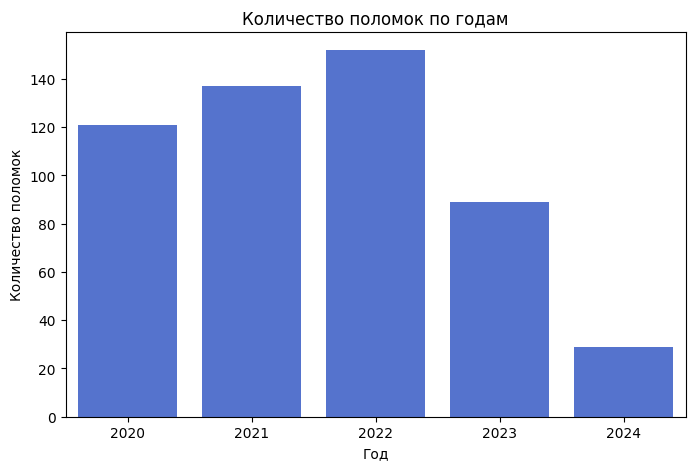

In [ ]:
# График количества поломок
plt.figure(figsize=(8,5))
sns.barplot(x=df["Год"], y=df["Кол-во поломок"], color='royalblue')
plt.xlabel("Год")
plt.ylabel("Количество поломок")
plt.title("Количество поломок по годам")
plt.show()

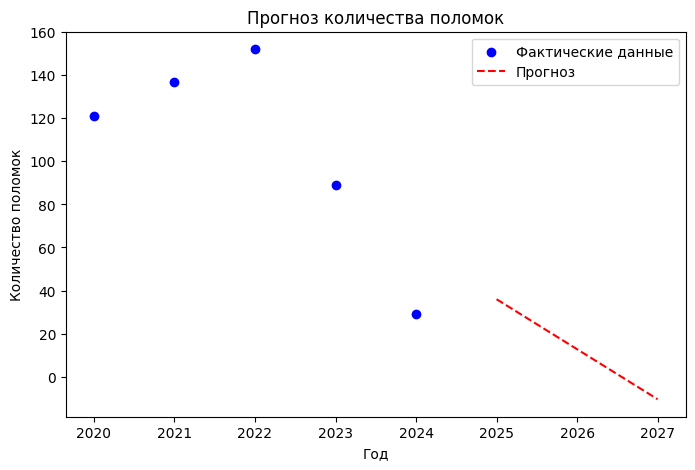

Прогноз количества поломок на 2025: 36.0


In [ ]:
# Линейная регрессия для прогноза количества поломок
from sklearn.linear_model import LinearRegression

X = df["Год"].values.reshape(-1,1)
y = df["Кол-во поломок"].values

model = LinearRegression()
model.fit(X, y)

future_years = np.array([2025, 2026, 2027]).reshape(-1,1)
predicted_failures = model.predict(future_years)

plt.figure(figsize=(8,5))
plt.scatter(df["Год"], df["Кол-во поломок"], color='blue', label="Фактические данные")
plt.plot(future_years, predicted_failures, color='red', linestyle="dashed", label="Прогноз")
plt.xlabel("Год")
plt.ylabel("Количество поломок")
plt.title("Прогноз количества поломок")
plt.legend()
plt.show()

print(f"Прогноз количества поломок на 2025: {predicted_failures[0]:.1f}")

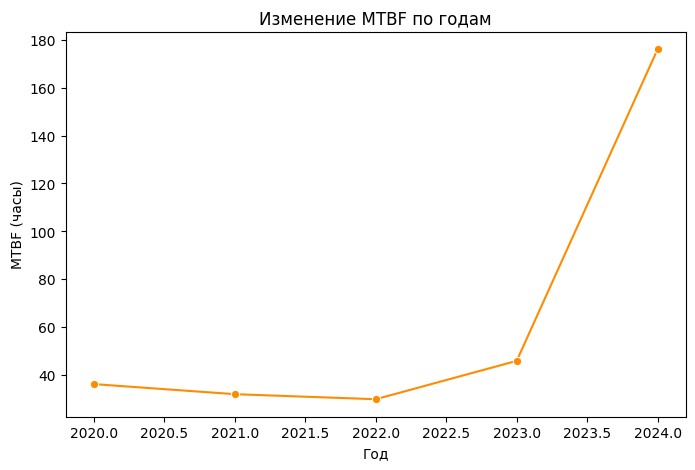

In [ ]:
# Анализ MTBF (время между поломками)
plt.figure(figsize=(8,5))
sns.lineplot(x=df["Год"], y=df["MTBF (часы)"], marker="o", color="darkorange")
plt.xlabel("Год")
plt.ylabel("MTBF (часы)")
plt.title("Изменение MTBF по годам")
plt.show()

In [ ]:
data = {
    'Год': [2020, 2021, 2022, 2023, 2024],
    'Удельные_затраты_на_ТО': [4.12, 3.32, 4.13, 5.05, 4.2],  # в условных единицах
    'Производительность_банок': [90000 * 0.33, 90000 * 0.33, 90000 * 0.33, 90000 * 0.33, 90000 * 0.33]  # банка/час * кол-во часов в год
}

df1 = pd.DataFrame(data)

df1['Затраты_на_ТО_на_единицу'] = df1['Удельные_затраты_на_ТО'] / df1['Производительность_банок']

print(df1[['Год', 'Затраты_на_ТО_на_единицу']])

    Год  Затраты_на_ТО_на_единицу
0  2020                  0.000139
1  2021                  0.000112
2  2022                  0.000139
3  2023                  0.000170
4  2024                  0.000141


In [ ]:
# Примерные данные (например, производительность в банках в час и MTBF в часах)
data = {
    "Год": [2020, 2021, 2022, 2023, 2024],
    "Затраты_на_ТО_на_единицу": [0.000139, 0.000112, 0.000139, 0.000170, 0.000141],
    "Производительность_банок_в_час": [90000, 90000, 90000, 90000, 90000],  # Производительность в банках в час
    "MTBF_час": [36.3, 32.1, 30, 46, 176],  # Среднее время между поломками в часах
    "Поломки_в_год": [121, 137, 152, 89, 29],  # Количество поломок в год
    "MTTR_мин": [4.9, 5.9, 7.6, 4.9, 9.2]  # Среднее время на ремонт в минутах
}

# Создаем DataFrame
df2 = pd.DataFrame(data)

# Преобразуем время на ремонт в часы
df2["MTTR_часы"] = df2["MTTR_мин"] / 60

# Рассчитываем количество часов простоя в год (поломки * MTTR)
df2["Часы_простоя_в_год"] = df2["Поломки_в_год"] * df2["MTTR_часы"]

# Рассчитываем затраты на ТО на год
df2["Затраты_на_ТО_в_год"] = df2["Затраты_на_ТО_на_единицу"] * df2["Производительность_банок_в_час"] * 24 * 365

# Рассчитываем затраты на поломки (стоимость на единицу * количество поломок)
df2["Затраты_на_поломки"] = df2["Затраты_на_ТО_на_единицу"] * df2["Производительность_банок_в_час"] * df2["Часы_простоя_в_год"]

# Выводим таблицу на экран
print(df2[["Год", "Затраты_на_ТО_в_год", "Затраты_на_поломки", "Часы_простоя_в_год"]])


    Год  Затраты_на_ТО_в_год  Затраты_на_поломки  Часы_простоя_в_год
0  2020             109587.6           123.61965            9.881667
1  2021              88300.8           135.79440           13.471667
2  2022             109587.6           240.85920           19.253333
3  2023             134028.0           111.20550            7.268333
4  2024             111164.4            56.42820            4.446667


В 2024 году затраты на ТО снизились, что может означать оптимизацию процессов обслуживания или снижение частоты техобслуживания.
Затраты на поломки заметно снизились с 2022 года, что может свидетельствовать о снижении количества поломок или улучшении состояния оборудования.
Часы простоя также снижаются с 2022 года, что подтверждает, что в последние годы оборудование работает эффективнее.

In [ ]:
# Расчет степени износа
recommended_hours = 15 * 4500
current_hours = 151126

wear_percentage = (current_hours / recommended_hours) * 100
print(f"Оборудование переработало {wear_percentage:.2f}% от рекомендованного срока")


Оборудование переработало 223.89% от рекомендованного срока


## Вывод

Прогноз количества поломок на 2025 год - 36.

- Замечено общее снижение количества поломок. В 2020–2022 годах число поломок росло, но затем резко упало в 2023–2024.
Возможные причины: улучшение обслуживания, замена компонентов или естественный износ, после которого слабые узлы уже заменены.
- MTBF резко вырос в 2024 году. В 2020–2022 годах время между поломками сокращалось (износ, частые поломки). В 2023–2024 значительный рост до 176 часов — возможно, оборудование прошло ремонт или нагрузка изменилась.
- MTTR (среднее время на ремонт) не изменилось кардинально.
В пределах 4.9–9.2 минут, что указывает на стабильность процессов ремонта.
- Оборудование переработало свой ресурс.
Производитель рекомендует 15 лет (≈ 67 500 часов работы).
Фактически оно отработало 151 126 моточасов (переработка более чем в 2 раза!).
Высока вероятность неожиданных отказов и критического износа.
- Прогноз поломок - если тенденция продолжится, то в 2025–2027 годах число поломок останется низким.
Но учитывая наработанные часы, возможно появление новых проблем, не фиксировавшихся ранее.
- Однако, если затраты на поломки остаются высокими, несмотря на улучшения, может быть полезно рассмотреть модернизацию или замену оборудования, чтобы снизить потери из-за поломок.


**Рекомендации**
-  Провести углубленную диагностику изношенных узлов (особенно кольцевой бак и вставки наполнителя).
- Оценить возможность модернизации системы управления.
- Запланировать замену оборудования, так как оно отработало свой срок.
